In [1]:
import numpy as np
from scipy import spatial 
import faiss
import typing
import time
import matplotlib.pyplot as plt
import gc  # Garbage collector


In [2]:
# pip install transformers datasets sentence-transformers cohere pinecone pinecone-client faiss-gpu tqdm


## Helper Function

In [3]:
def generate_vectors(
        num_vectors: int,
        dim: int,
        seed: int = 42,
) -> np.ndarray:
    """
    This function generates random vectors of uniform distribution.
    Args:
        num_vectors: The number of vectors to generate.
        dim: The dimensionality of the vectors.
        seed: The random seed.
    Returns:
        An array of shape (num_vectors, dim) containing the generated vectors.
    """
    np.random.seed(seed)
    return np.random.uniform(0, 1, (num_vectors, dim))

In [4]:
def naive_exhaustive_search(
        query_vectors: np.ndarray,
        index_vectors: np.ndarray, 
        k: int,
) -> np.ndarray:
    """
    This function computes the k-nearest neighbors of query_vectors in index_vectors using the naive exhaustive approach.
    Args:
        query_vectors: An array of shape (n_queries, dim) containing the query vectors. 
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        k: The number of nearest neighbors to retrieve.
    Returns:
        An array of shape (n_queries, k) containing the indices of the k-nearest neighbors for each query vector.
    """
    all_distances = []
    for query_vector in query_vectors:
        query_distances = []
        for index_vector in index_vectors:
            query_distances.append(spatial.distance.euclidean(query_vector, index_vector))
        all_distances.append(np.argsort(query_distances)[:k])
    return np.array(all_distances)

In [5]:
def optimized_exhaustive_search(
        query_vectors: np.ndarray,
        index_vectors: np.ndarray,
        k: int,
):
    """
    This function computes the k-nearest neighbors of query_vectors in index_vectors using the optimized exhaustive approach implemented in SciPy.
    Args:
        query_vectors: An array of shape (n_queries, dim) containing the query vectors. 
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        k: The number of nearest neighbors to retrieve.
    Returns:
        An array of shape (n_queries, k) containing the indices of the k-nearest neighbors for each query vector.
    """
    distances = spatial.distance.cdist(query_vectors, index_vectors, 'euclidean')
    return np.argsort(distances, axis=1)[:, :k]

In [6]:
def build_faiss_flatl2_index(
        index_vectors: np.ndarray,
        dim: int,
):
    """
    This function builds a Faiss flat L2 index.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        dim: The dimensionality of the vectors. 
    Returns:
        A Faiss flat L2 index.
    """
    index = faiss.IndexFlatL2(dim)
    index.add(index_vectors)
    return index

In [7]:
def faiss_search(
        query_vectors: np.ndarray,
        index: faiss.Index,
        k: int,
):
    """
    This function uses a Faiss index to search for the k-nearest neighbors of query_vectors.
    Args:
        query_vectors: An array of shape (n_queries, dim) containing the query vectors. 
        index: A Faiss index.
        k: The number of nearest neighbors to retrieve.
    Returns:
        An array of shape (n_queries, k) containing the indices of the k-nearest neighbors for each query vector.
    """
    distances, indices = index.search(query_vectors, k)
    return indices

In [8]:
def build_faiss_lsh_index(
        index_vectors: np.ndarray,
        dim: int,
        nbits: int,
):
    """
    This function builds a Faiss LSH index.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        dim: The dimensionality of the vectors. 
        nbits: The number of bits to use in the hash.
    Returns:
        A Faiss LSH index.
    """
    index = faiss.IndexLSH(dim, nbits)
    index.add(index_vectors)
    return index

In [9]:
def compute_recall_at_k(
        true_indices: np.ndarray,
        faiss_indices: np.ndarray,
        k: int,
):
    """
    This function computes the recall@k.
    Args:
        true_indices: The ground truth nearest neighbors.
        faiss_indices: The approximate nearest neighbors.
        k: The number of nearest neighbors to consider.
    Returns:
        The recall@k.
    """
    recalls = []
    for true, faiss in zip(true_indices, faiss_indices):
        recall = len(set(true[:k]) & set(faiss[:k])) / k
        recalls.append(recall)
    return np.mean(recalls)

My utils

In [14]:
# Naive exhaustive search
def my_naive_exhaustive_search(index, queries):
    results = []
    for query in queries:
        distances = np.linalg.norm(index - query, axis=1)
        results.append(np.argmin(distances))
    return results

# Optimized exhaustive search using NumPy broadcasting
def my_optimized_exhaustive_search(index, queries):
    distances = np.linalg.norm(index[None, :, :] - queries[:, None, :], axis=2)
    return np.argmin(distances, axis=1)

# FAISS flatL2 search
def faiss_flatL2(index, queries):
    index_flat = faiss.IndexFlatL2(index.shape[1])
    index_flat.add(index)
    _, results = index_flat.search(queries, 1)
    return results

# Helper function to measure running time
def measure_time(method, index, queries, k=None):
    if k is None:
        start_time = time.time()
        method(index, queries)
        return time.time() - start_time
    else:
        start_time = time.time()
        method(index, queries, k)
        return time.time() - start_time

# 1.1 - Running Time Comparison

You are given three methods for vector search:
<ol>
 <li> naive_exhaustive_search </li> 
 <li> optimized_exhaustive_search </li> 
 <li> faiss_flatL2 </li> 
</ol>

each one implements vector search with different levels of optimization. Your task is to compare the running time of these three methods. 
You need to complete the code so that the generated plots should reflect the increasing difference in running time between the methods, as a function of the desired parameters.
The plots should be clear and self-explanatory, including the labels, title, and legend.
There is no need to experiment with long running times (few seconds are enough for each plot); just ensure that the trends are visible.
You are allowed to add more cells between the TODOs, but do not flip the order of the subsections.
When you finish. do not forget to attach the plots to report.pdf, placed under a clear title indicating the section number.

### Generate the following plots:
##### 1.1.1. Running time of the three methods as a function of the number of vectors in the index (x-axis) with the following parameters fixed:
* vector dimensionality: 100
* number of vectors in the query set: 1000
##### 1.1.2. Running time of the three methods as a function of the dimensionality of the vectors (x-axis) with the following parameters fixed:
* number of vectors in the index: 100000
* number of vectors in the query set: 1000

1.1.1 Running time as a function of the number of vectors in the index


In [15]:
# 1.1.1 Running time as a function of the number of vectors in the index
vector_dimensionality = 100
query_set_size = 1000
k=1

index_sizes = [250, 500, 750, 1000, 2500, 5000, 7500, 10000, 25000, 50000, 75000, 100000]
times_naive = []
times_optimized = []
times_faiss = []

for size in index_sizes:
    print(size)
    index = generate_vectors(size, vector_dimensionality).astype(np.float32)
    queries = generate_vectors(query_set_size, vector_dimensionality).astype(np.float32)
    times_naive.append(measure_time(naive_exhaustive_search, index, queries, k))
    times_optimized.append(measure_time(optimized_exhaustive_search, index, queries, k))
    times_faiss.append(measure_time(faiss_flatL2, index, queries))
    
    # Clear cache and call garbage collector
    del index, queries
    gc.collect()

250
500
750
1000
2500
5000
7500
10000
25000


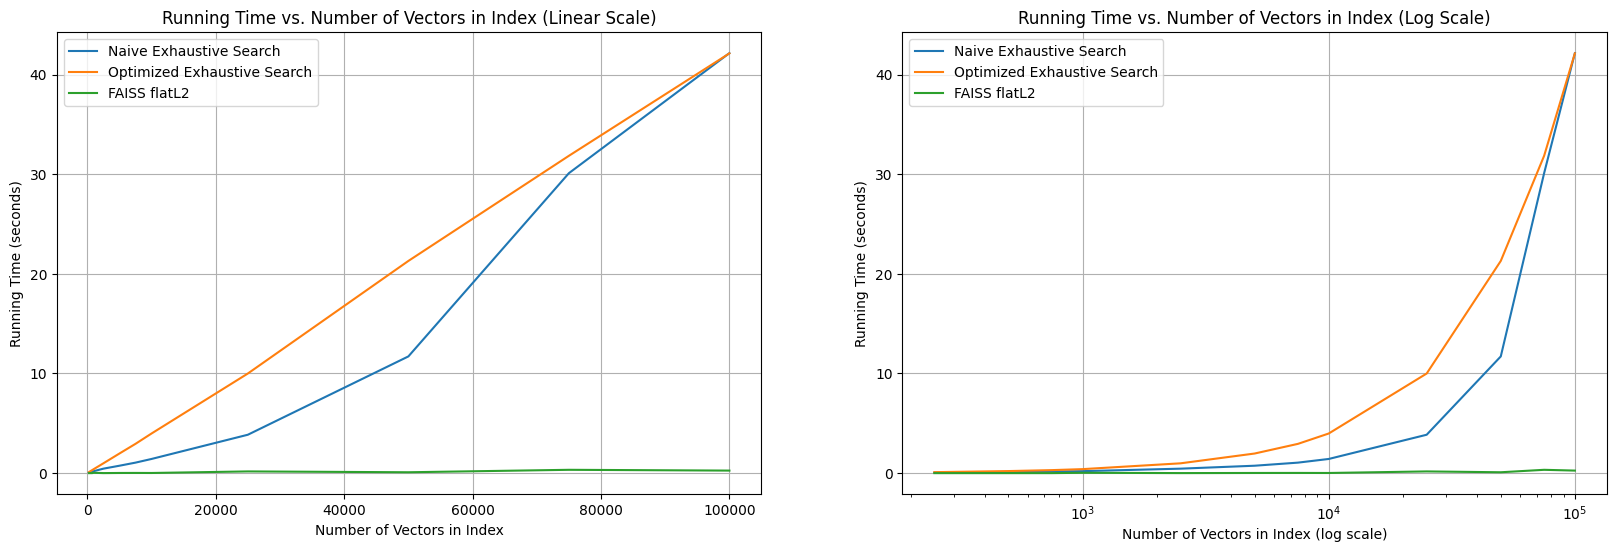

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# Plot with linear x-axis
axs[0].plot(index_sizes, times_naive, label='Naive Exhaustive Search')
axs[0].plot(index_sizes, times_optimized, label='Optimized Exhaustive Search')
axs[0].plot(index_sizes, times_faiss, label='FAISS flatL2')
axs[0].set_xlabel('Number of Vectors in Index')
axs[0].set_ylabel('Running Time (seconds)')
axs[0].set_title('Running Time vs. Number of Vectors in Index (Linear Scale)')
axs[0].legend()
axs[0].grid(True)

# Plot with log-scaled x-axis
axs[1].plot(index_sizes, times_naive, label='Naive Exhaustive Search')
axs[1].plot(index_sizes, times_optimized, label='Optimized Exhaustive Search')
axs[1].plot(index_sizes, times_faiss, label='FAISS flatL2')
axs[1].set_xscale('log')
axs[1].set_xlabel('Number of Vectors in Index (log scale)')
axs[1].set_ylabel('Running Time (seconds)')
axs[1].set_title('Running Time vs. Number of Vectors in Index (Log Scale)')
axs[1].legend()
axs[1].grid(True)

plt.show()

In [11]:
# 1.1.2 Running time as a function of the dimensionality of the vectors
index_size = 100000
query_set_size = 1000

vector_dims = [1, 5, 10, 20, 30, 50, 75, 100, 125]
times_naive = []
times_optimized = []
times_faiss = []

for dim in vector_dims:
    print(dim)
    index = generate_vectors(index_size, dim).astype(np.float32)
    queries = generate_vectors(query_set_size, dim).astype(np.float32)
    times_naive.append(measure_time(my_naive_exhaustive_search, index, queries))
    times_optimized.append(measure_time(my_optimized_exhaustive_search, index, queries))
    times_faiss.append(measure_time(faiss_flatL2, index, queries))
    
    # Clear cache and call garbage collector
    del index, queries
    gc.collect()

1
5
10
20
30
50
75
100
125


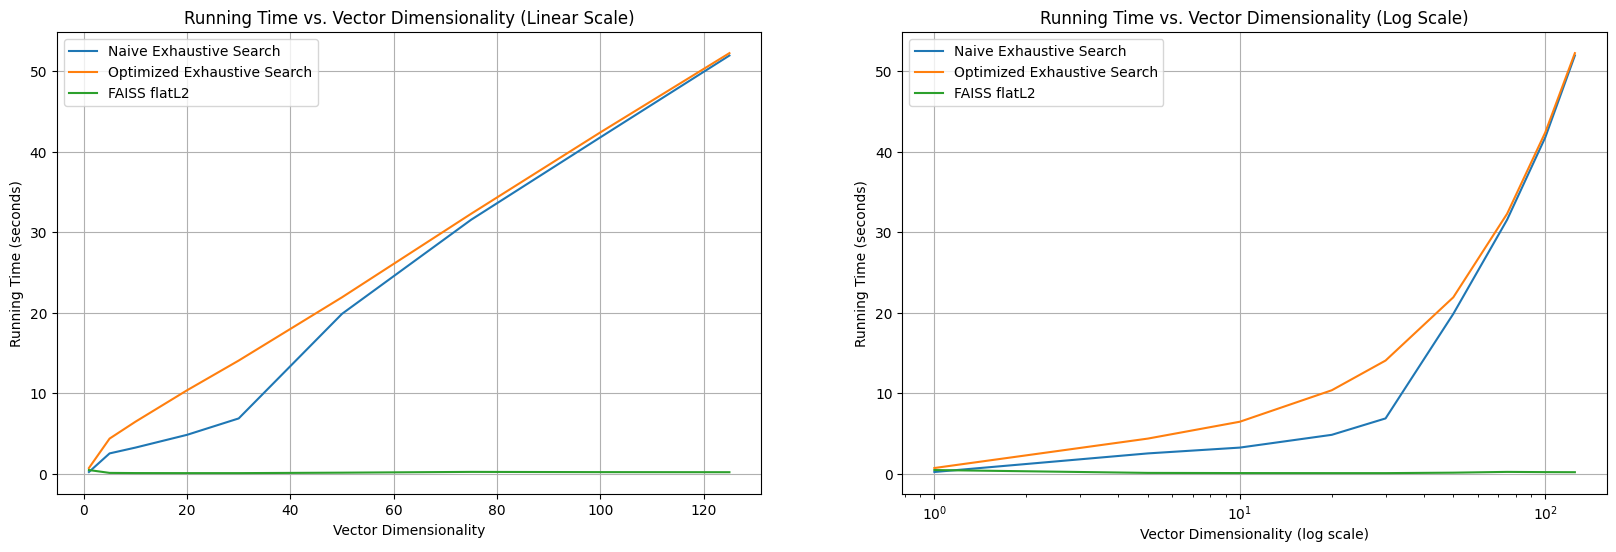

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# Plot with linear x-axis
axs[0].plot(vector_dims, times_naive, label='Naive Exhaustive Search')
axs[0].plot(vector_dims, times_optimized, label='Optimized Exhaustive Search')
axs[0].plot(vector_dims, times_faiss, label='FAISS flatL2')
axs[0].set_xlabel('Vector Dimensionality')
axs[0].set_ylabel('Running Time (seconds)')
axs[0].set_title('Running Time vs. Vector Dimensionality (Linear Scale)')
axs[0].legend()
axs[0].grid(True)

# Plot with log-scaled x-axis
axs[1].plot(vector_dims, times_naive, label='Naive Exhaustive Search')
axs[1].plot(vector_dims, times_optimized, label='Optimized Exhaustive Search')
axs[1].plot(vector_dims, times_faiss, label='FAISS flatL2')
axs[1].set_xscale('log')
axs[1].set_xlabel('Vector Dimensionality (log scale)')
axs[1].set_ylabel('Running Time (seconds)')
axs[1].set_title('Running Time vs. Vector Dimensionality (Log Scale)')
axs[1].legend()
axs[1].grid(True)

plt.show()

# 1.2 -- Faiss LSH
### Create the following plots:
##### 1.2.1. Running time of Faiss LSH as a function of the number of vectors in the index (x-axis) with the following parameters fixed:
* vector dimensionality: 100
* number of vectors in the query set: 1000
* nbits: 500

##### 1.2.2. Running time of Faiss LSH as a function of nbits (x-axis) with the following parameters fixed:
* vector dimensionality: 100
* number of vectors in the query set: 1000
* number of vectors in the index: 500000


##### 1.2.3. recall@k of Faiss LSH as a function of nbits (x-axis) with the following parameters fixed:
* vector dimensionality: 100
* number of vectors in the query set: 1000
* number of vectors in the index: 500000
* k: 10


You need to complete the code so that the generated plots should reflect the desired metrics as a function of the desired parameters.
The plots should be clear and self-explanatory, including the labels, title, and legend.
There is no need to experiment with long running times (few seconds are enough for each plot); just ensure that the trends are visible.
You are allowed to add more cells between the TODOs, but do not flip the order of the subsections.
When you finish. do not forget to attach the plots to report.pdf, placed under a clear title indicating the section number.


20
50
100
250
500
750
1000
2500
5000
7500
10000
25000
50000
75000
100000


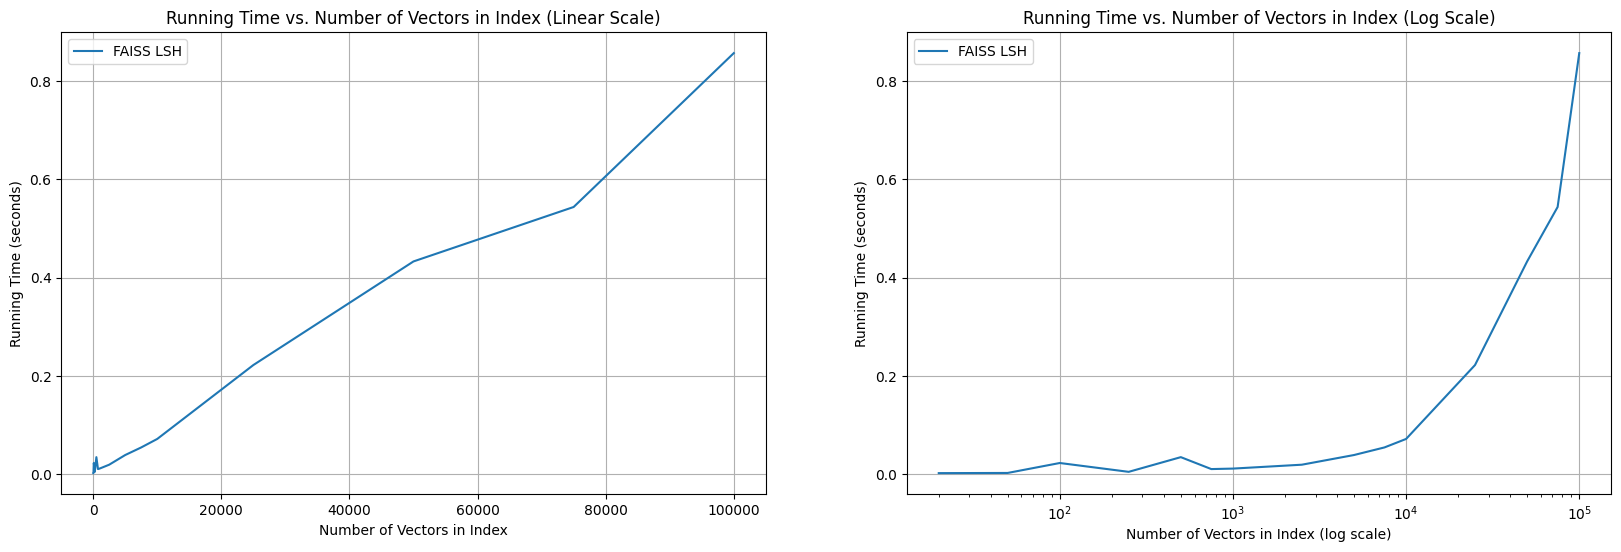

In [21]:
vector_dimensionality = 100
query_set_size = 1000
nbits = 500
k = 5  # Number of nearest neighbors

index_sizes = [20, 50, 100, 250, 500, 750, 1000, 2500, 5000, 7500, 10000, 25000, 50000, 75000, 100000]
times_faiss_lsh = []

for size in index_sizes:
    print(size)
    index = generate_vectors(size, vector_dimensionality).astype(np.float32)
    queries = generate_vectors(query_set_size, vector_dimensionality).astype(np.float32)
    
    faiss_index = build_faiss_lsh_index(index, vector_dimensionality, nbits)
    times_faiss_lsh.append(measure_time(faiss_search, queries, faiss_index, k))
    
    # Clear cache and call garbage collector
    del index, queries, faiss_index
    gc.collect()
    
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# Plot with linear x-axis
axs[0].plot(index_sizes, times_faiss_lsh, label='FAISS LSH')
axs[0].set_xlabel('Number of Vectors in Index')
axs[0].set_ylabel('Running Time (seconds)')
axs[0].set_title('Running Time vs. Number of Vectors in Index (Linear Scale)')
axs[0].legend()
axs[0].grid(True)

# Plot with log-scaled x-axis
axs[1].plot(index_sizes, times_faiss_lsh, label='FAISS LSH')
axs[1].set_xscale('log')
axs[1].set_xlabel('Number of Vectors in Index (log scale)')
axs[1].set_ylabel('Running Time (seconds)')
axs[1].set_title('Running Time vs. Number of Vectors in Index (Log Scale)')
axs[1].legend()
axs[1].grid(True)

plt.show()

25
50
100
200
300
400
500
600
700
800
900
1000


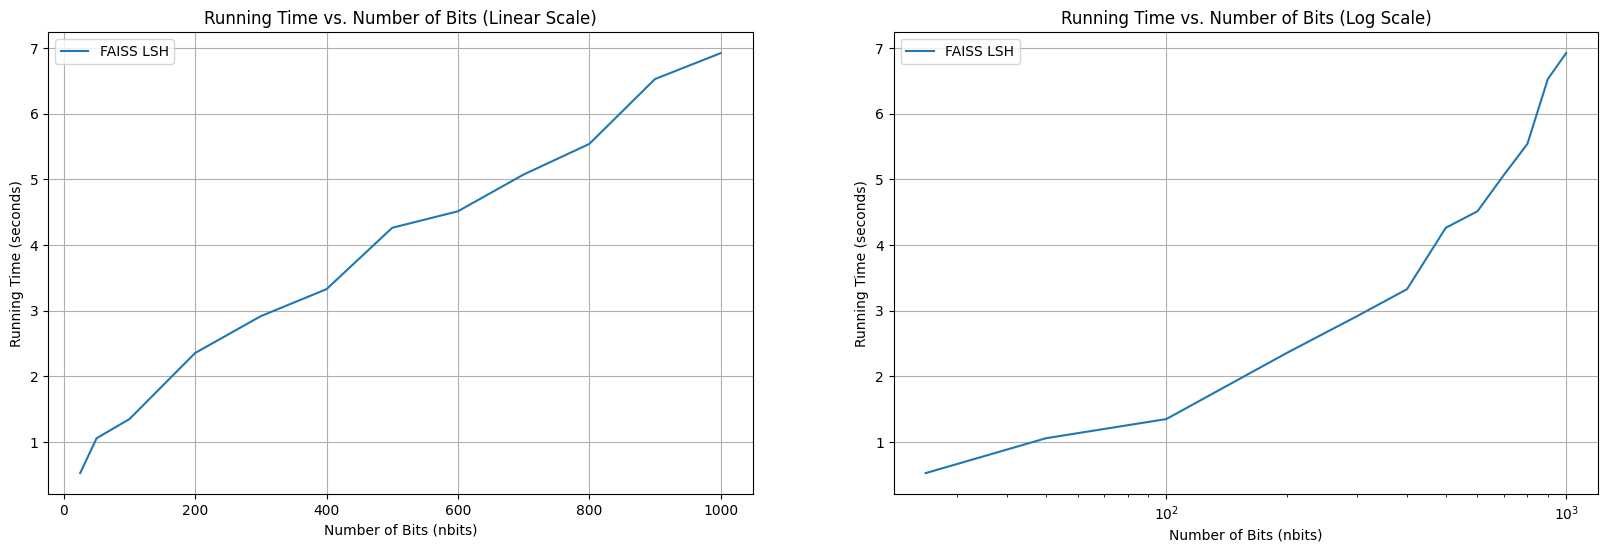

In [25]:
# 1.2.2 Running time of Faiss LSH as a function of nbits
vector_dimensionality = 100
query_set_size = 1000
index_size = 500000
k = 5  # Number of nearest neighbors

nbits_values = [25, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
times_faiss_lsh_nbits = []

index = generate_vectors(index_size, vector_dimensionality).astype(np.float32)
queries = generate_vectors(query_set_size, vector_dimensionality).astype(np.float32)

for nbits in nbits_values:
    print(nbits)
    faiss_index = build_faiss_lsh_index(index, vector_dimensionality, nbits)
    times_faiss_lsh_nbits.append(measure_time(faiss_search, queries, faiss_index, k))
    
    # Clear cache and call garbage collector
    del faiss_index
    gc.collect()
    
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# Plot with linear x-axis
axs[0].plot(nbits_values, times_faiss_lsh_nbits, label='FAISS LSH')
axs[0].set_xlabel('Number of Bits (nbits)')
axs[0].set_ylabel('Running Time (seconds)')
axs[0].set_title('Running Time vs. Number of Bits (Linear Scale)')
axs[0].legend()
axs[0].grid(True)

# Plot with log-scaled x-axis
axs[1].plot(nbits_values, times_faiss_lsh_nbits, label='FAISS LSH')
axs[1].set_xscale('log')
axs[1].set_xlabel('Number of Bits (nbits)')
axs[1].set_ylabel('Running Time (seconds)')
axs[1].set_title('Running Time vs. Number of Bits (Log Scale)')
axs[1].legend()
axs[1].grid(True)

plt.show()


25
50
100
200
300
400
500
600
700
800
900
1000


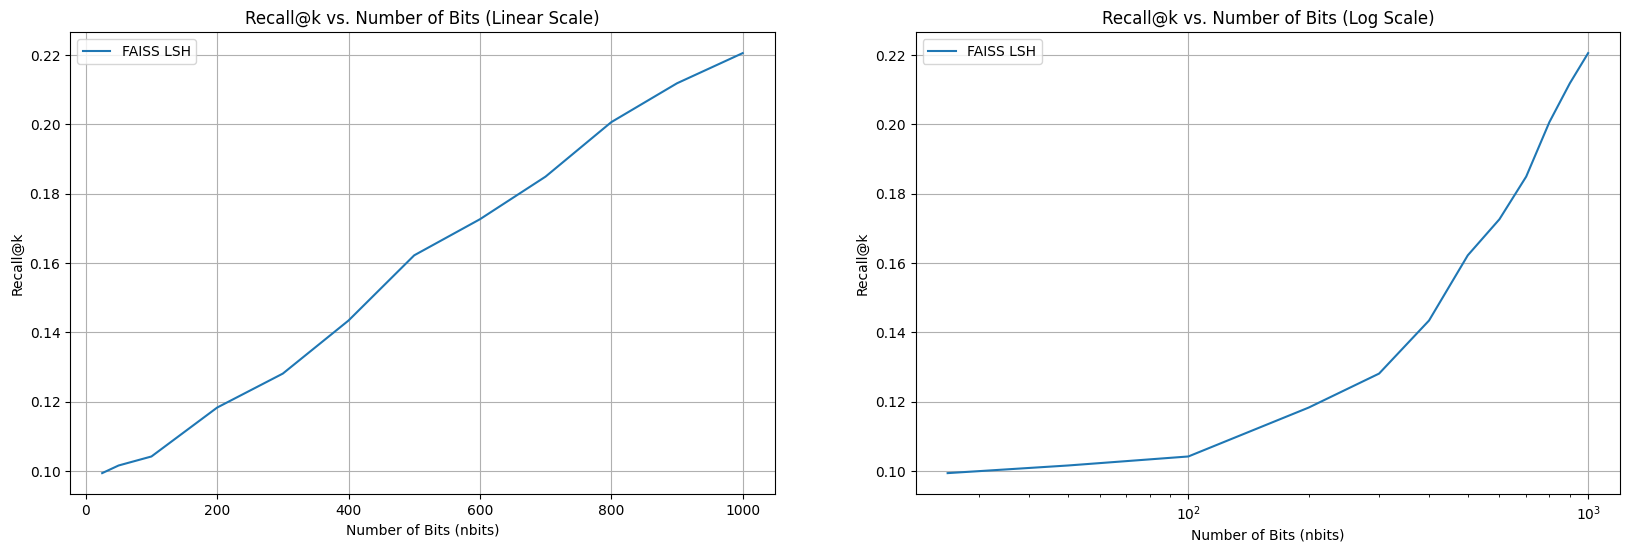

In [16]:
# 1.2.3 Recall@k of Faiss LSH as a function of nbits
vector_dimensionality = 100
query_set_size = 1000
index_size = 500000
k = 10  # Number of nearest neighbors for recall calculation

nbits_values = [25, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
recalls_faiss_lsh = []

index = generate_vectors(index_size, vector_dimensionality).astype(np.float32)
queries = generate_vectors(query_set_size, vector_dimensionality).astype(np.float32)

# Calculate true nearest neighbors using optimized exhaustive search
true_indices = optimized_exhaustive_search(queries, index, k)

for nbits in nbits_values:
    print(nbits)
    faiss_index = build_faiss_lsh_index(index, vector_dimensionality, nbits)
    faiss_indices = faiss_search(queries, faiss_index, k)
    recall = compute_recall_at_k(true_indices, faiss_indices, k)
    recalls_faiss_lsh.append(recall)
    
    # Clear cache and call garbage collector
    del faiss_index, faiss_indices, recall
    gc.collect()
    
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# Plot with linear x-axis
axs[0].plot(nbits_values, recalls_faiss_lsh, label='FAISS LSH')
axs[0].set_xlabel('Number of Bits (nbits)')
axs[0].set_ylabel('Recall@k')
axs[0].set_title('Recall@k vs. Number of Bits (Linear Scale)')
axs[0].legend()
axs[0].grid(True)

# Plot with log-scaled x-axis
axs[1].plot(nbits_values, recalls_faiss_lsh, label='FAISS LSH')
axs[1].set_xscale('log')
axs[1].set_xlabel('Number of Bits (nbits)')
axs[1].set_ylabel('Recall@k')
axs[1].set_title('Recall@k vs. Number of Bits (Log Scale)')
axs[1].legend()
axs[1].grid(True)

plt.show()